# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
take_random_actions_run = True  # Set to False if you want to see this!

if not take_random_actions_run:
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    print("Score: {}".format(score))

When finished, you can close the environment.

### 4. Let's train an agent using DQN!

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import time
import os
import torch
import random
import numpy as np
import dqn_agent
import matplotlib.pyplot as plt

from collections import deque

%matplotlib inline

In [9]:
# For changes in the dqn_agent.py script
import imp
imp.reload(dqn_agent)

C:\Users\a.charalampous\deep-reinforcement-learning\p1_navigation\dqn_agent.py:31: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self._true_xor(apply_dueling, apply_double),


<module 'dqn_agent' from 'C:\\Users\\a.charalampous\\deep-reinforcement-learning\\p1_navigation\\dqn_agent.py'>

In [11]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train_mode=True, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """
    DQN network in action!
    
    :param n_episodes: (int) maximum number of training episodes
    :param max_t: (int):maximum number of timesteps per episode
    :param eps_start: (float) starting value of epsilon, for epsilon-greedy action selection
    :param eps_end: (float) minimum value of epsilon
    :param eps_decay: (float) multiplicative factor (per episode) for decreasing epsilon
    :param train_mode: (bool) if 'True' set environment to training mode
    :param ckpt_path: (str) The relative path to save a model checkpoint, if it achieves the desired average score
    :return: (array-like, array-like) The scores and moving averages achieved at every (training) time step
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t):           
            # action = np.random.randint(action_size)        # select an action
            action = agent.act(state, eps)
            action = action.astype(int)                    # Convert to np.int32, as an np.int64 will generate errors..
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if moving_avg >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            if train_mode:
                root_ckpt_path = os.path.exists(ckpt_path.split("/")[0])
                if not os.path.exists(root_ckpt_path):
                    os.mkdir(root_ckpt_path)

                torch.save(agent.q_net_local.state_dict(), ckpt_path)
            break
    return scores, moving_avgs

Let's try training an agent with the baseline model first. 

We will summarise all our results later in this notebook to find the best configuration (from a set of a few runs)!

In [9]:
# Train the agent using DQN
agent = dqn_agent.Agent(state_size=37, action_size=4, seed=52, apply_double=False, apply_dueling=False)
ckpt_path='pth_checkpoints/checkpoint.pth'

start_time = time.time() # Monitor Training Time  
scores, moving_avgs = dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 100	Average Score: 1.08
Episode 200	Average Score: 4.62
Episode 300	Average Score: 7.44
Episode 400	Average Score: 9.53
Episode 500	Average Score: 12.36
Episode 600	Average Score: 12.81
Episode 607	Average Score: 13.00
Environment solved in 507 episodes!	Average Score: 13.00

Total Training time = 14.4 min


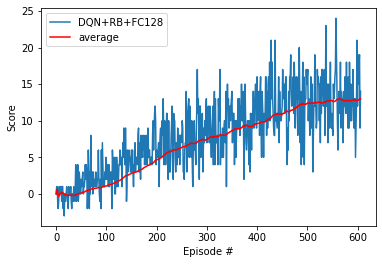

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN+RB+FC128')
plt.plot(np.arange(len(scores)), moving_avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [12]:
# Train the agent using DDQN
ddqn_agent = dqn_agent.Agent(state_size=37, action_size=4, seed=52, apply_double=True, apply_dueling=False)
ckpt_path='pth_checkpoints/ddqn_checkpoint.pth'

start_time = time.time() # Monitor Training Time  
ddqn_scores, ddqn_moving_avgs = dqn(ddqn_agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
                                    ckpt_path=ckpt_path)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 100	Average Score: 0.63
Episode 200	Average Score: 3.32
Episode 300	Average Score: 6.91
Episode 400	Average Score: 9.54
Episode 500	Average Score: 12.61
Episode 510	Average Score: 13.07
Environment solved in 410 episodes!	Average Score: 13.07

Total Training time = 16.1 min


The DDQN algorithm performs slightly better!

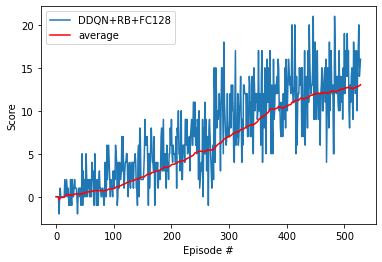

In [16]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_scores)), ddqn_scores, label='DDQN+RB+FC128')
plt.plot(np.arange(len(ddqn_scores)), ddqn_moving_avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

Let's also test the dueling networks implementation

In [10]:
# Train the agent using DDQN
duel_agent = dqn_agent.Agent(state_size=37, action_size=4, seed=52, apply_double=False, apply_dueling=True)
ckpt_path='pth_checkpoints/duel_checkpoint.pth'

start_time = time.time() # Monitor Training Time  
duel_scores, duel_moving_avgs = dqn(duel_agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
                                    ckpt_path=ckpt_path)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 100	Average Score: 1.01
Episode 200	Average Score: 3.33
Episode 300	Average Score: 6.96
Episode 400	Average Score: 9.88
Episode 500	Average Score: 12.16
Episode 540	Average Score: 13.02
Environment solved in 440 episodes!	Average Score: 13.02

Total Training time = 14.7 min


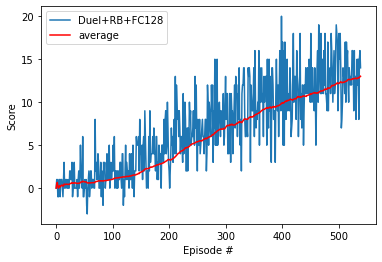

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(duel_scores)), duel_scores, label='Duel+RB+FC128')
plt.plot(np.arange(len(duel_scores)), duel_moving_avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

The winner, by a small margin, are DDQNs. Of course, to verify this, we will need to run the experiments for a lot more times and with different parameter settings, which is out of the scope of this project at the moment.